## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_sea = pd.read_csv("/Users/PKLAT/Desktop/Edureka/TimeSeries/SeaPlaneTravel.csv")

In [3]:
df_sea.head()

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121


In [4]:
df_sea.Month = pd.to_datetime(df_sea.Month)   # Converting Month column to datetime format

In [5]:
df_sea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [6]:
df_sea.set_index('Month', inplace=True)   #Set Month column as index

In [7]:
df_sea

,#Passengers
Month,
2003-01-01,112
2003-02-01,118
2003-03-01,132
2003-04-01,129
2003-05-01,121
...,...
2015-08-01,606
2015-09-01,508
2015-10-01,461


## Data Visualisation

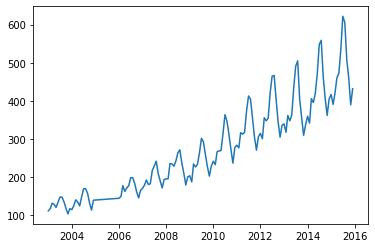

In [8]:
plt.plot(df_sea['#Passengers'])
plt.show()

## Building the ARIMA Model

In [10]:
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.arima_model import ARIMA

### Function to check if our data is stationary

In [11]:
def stationary_test(ts):
    rolling_mean = ts.rolling(window=12, center=False).mean()
    rolling_std = ts.rolling(window=12, center=False).std()
    
    plt.plot(ts, linestyle='--', label='original')
    plt.plot(rolling_mean, linestyle='--', label='rolling mean')
    plt.plot(rolling_std, linestyle='--', label='rolling std')
    plt.legend(loc='best')
    
    plt.show(block=False)
    
    ad = adfuller(ts)
    
    print('T-Stat:', ad[0])
    print('p-value:', ad[1])
    print('n_lag used:', ad[2])
    print('n_obs_used:', ad[3])
    
    for key in ad[4].keys():
        print("critical", key, ad[4][key])

In [12]:
ts_sea = df_sea['#Passengers']

In [13]:
ts_sea_log = np.log(ts_sea)

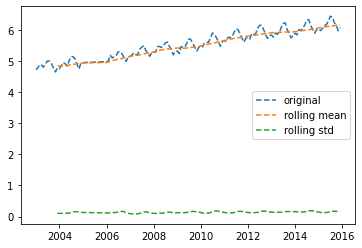

T-Stat: -1.7170170891069714
p-value: 0.4223667747703857
n_lag used: 13
n_obs_used: 130
critical 1% -3.4816817173418295
critical 5% -2.8840418343195267
critical 10% -2.578770059171598


In [14]:
stationary_test(ts_sea_log)

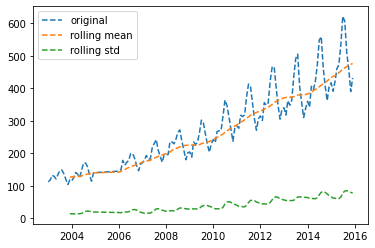

T-Stat: 0.8153688792060423
p-value: 0.9918802434376409
n_lag used: 13
n_obs_used: 130
critical 1% -3.4816817173418295
critical 5% -2.8840418343195267
critical 10% -2.578770059171598


In [15]:
stationary_test(df_sea)

### Differentiating the data to make it stationary

In [16]:
ts_sea_log_diff = ts_sea_log - ts_sea_log.shift() 

In [17]:
ts_sea_log_diff.dropna(inplace=True, axis=0)

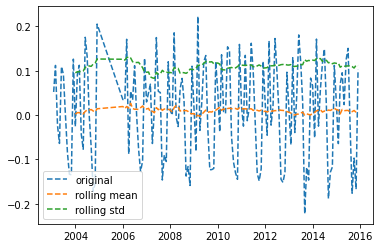

T-Stat: -2.717130598388145
p-value: 0.0711205481508568
n_lag used: 14
n_obs_used: 128
critical 1% -3.4825006939887997
critical 5% -2.884397984161377
critical 10% -2.578960197753906


In [18]:
stationary_test(ts_sea_log_diff)

### Differentiating the data again such that T-Stat is less than at least critical 5 %

In [20]:
ts_sea_log_diff2 = ts_sea_log_diff - ts_sea_log_diff.shift()

In [21]:
ts_sea_log_diff2.dropna(inplace=True)

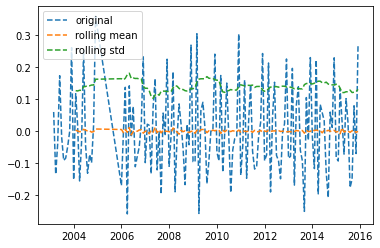

T-Stat: -8.196629132182192
p-value: 7.419304549378255e-13
n_lag used: 13
n_obs_used: 128
critical 1% -3.4825006939887997
critical 5% -2.884397984161377
critical 10% -2.578960197753906


In [22]:
stationary_test(ts_sea_log_diff2)

In [23]:
d = 2  #since we differentiated the data twice to make it stationary, value of d=2

### Calculating the n_obs and n_lags

In [24]:
n_acf = acf(ts_sea_log_diff2, nlags=10)
n_pacf = pacf(ts_sea_log_diff2, nlags=10, method='ols')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


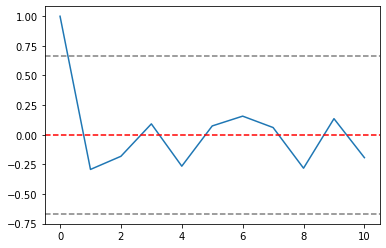

In [25]:
plt.plot(n_acf)
plt.axhline(y=0, linestyle='--', color='r')
plt.axhline(y=-7.96/np.sqrt(len(ts_sea_log_diff2)), linestyle='--', color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_sea_log_diff2)), linestyle='--', color='grey')

In [26]:
q=0  #q value acf graph----cutting uper confidence

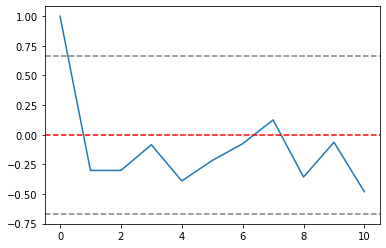

In [27]:
plt.plot(n_pacf)
plt.axhline(y=0, linestyle='--', color='r')
plt.axhline(y=-7.96/np.sqrt(len(ts_sea_log_diff2)), linestyle='--', color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_sea_log_diff2)), linestyle='--', color='grey')

In [28]:
p=1 #p value pacf graph---becoming zero first time

#### Making the prediction

In [29]:
train = ts_sea_log[:-15]
test = ts_sea_log[-15:]

In [30]:
pred=[]
history = [x for x in train]

In [31]:
for i in range(len(test)):
    model=ARIMA(history, order=(p,d,q))
    model_fit = model.fit(disp=0)
    predcition_value = model_fit.forecast()
    yhat = float(predcition_value[0])
    pred.append(yhat)
    history.append(test[i])    
    print('predicted',np.exp(yhat),'actual',np.exp(test[i]))

predicted 407.8275626555571 actual 406.99999999999983
predicted 350.57707296764596 actual 362.00000000000017
predicted 320.2199527518327 actual 404.99999999999983
predicted 422.6245172924729 actual 417.0
predicted 440.27592071533536 actual 391.0
predicted 376.6715727790192 actual 418.9999999999999
predicted 430.9893061997606 actual 461.00000000000006
predicted 503.31715926127947 actual 471.99999999999983
predicted 493.7398434205373 actual 534.9999999999999
predicted 588.1496442757996 actual 621.9999999999999
predicted 718.1701179108901 actual 605.9999999999999
predicted 622.6295728555801 actual 508.00000000000006
predicted 443.89287011316355 actual 461.00000000000006
predicted 408.114247913125 actual 390.00000000000006
predicted 336.10855735221384 actual 432.00000000000017


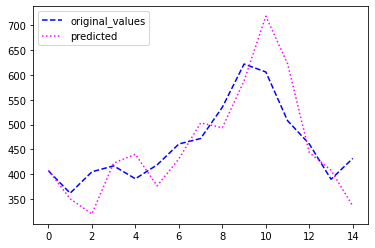

In [32]:
plt.plot(np.exp(test.values), linestyle='--', color='blue', label='original_values')
plt.plot(np.exp(pred), linestyle=':', color='magenta', label='predicted')
plt.legend(loc='best')
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error

In [34]:
mean_absolute_error(pred,test.values)

0.09885596309732456